In [123]:
import csv
from itertools import islice
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
from torchvision import models, datasets, transforms

In [124]:
dataset_counts = defaultdict(int)
img_counts = defaultdict(lambda : defaultdict(int))
unique_imgs = defaultdict(set)

with open('../all_gans_inf.csv') as f:
    reader = csv.DictReader(f)
    for row in islice(reader, None):
        img = row['img']        
#         dataset_name = img[:img.index('/')]
        split_name = img.split('/')
        assert(len(split_name) == 2)
        dataset_name, img_name = split_name
        dataset_counts[dataset_name] += 1
        img_counts[dataset_name][img_name] += 1
unique_imgs = {dataset: len(img_counts[dataset]) for dataset in img_counts}

In [125]:
# count of total labels per dataset
dataset_counts

defaultdict(int,
            {'ffhq500': 7837,
             'styleganwithtrunc5000': 4409,
             'stylegannotrunc5000': 3406,
             'celeba500': 17722,
             'wgangp5000': 6673,
             'styleganceleba5000': 4797,
             'began5000': 3235,
             'progan5000': 2986})

In [126]:
# count of unique images with labels per dataset
unique_imgs


{'ffhq500': 50,
 'styleganwithtrunc5000': 1621,
 'stylegannotrunc5000': 2459,
 'celeba500': 66,
 'wgangp5000': 4251,
 'styleganceleba5000': 3103,
 'began5000': 2397,
 'progan5000': 2233}

In [127]:
inception_net = models.inception_v3(pretrained=True, transform_input=True)

In [128]:
inception_transforms = transforms.Compose([
            transforms.Resize(299),
            #transforms.CenterCrop(constants.INPUT_SIZE),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [129]:
progan_images = datasets.ImageFolder('progan_imgs/', inception_transforms)

In [130]:
progan_images

Dataset ImageFolder
    Number of datapoints: 300
    Root location: progan_imgs/

In [131]:
progan_loader = torch.utils.data.DataLoader(
        progan_images, batch_size=1, shuffle=True, num_workers=1)

In [132]:
layers_to_grab = [inception_net.Conv2d_1a_3x3, inception_net.Conv2d_2b_3x3,
                 inception_net.Conv2d_3b_1x1, inception_net.Mixed_5d, inception_net.Mixed_6e,
                 inception_net.Mixed_7c, inception_net.fc]

example_activations = []
cur_activations = []

def hook_fn(self, inp, out):
    global cur_activations
    global example_activations
    #print(inp[0].shape, out.shape)
    cur_activations.append(out)
    if len(cur_activations) == len(layers_to_grab):
        example_activations.append(torch.cat([x.reshape(-1) for x in cur_activations]))
        cur_activations = []



for layer in layers_to_grab:
    layer.register_forward_hook(hook_fn)

torch.Size([1, 3, 299, 299]) tensor([0])


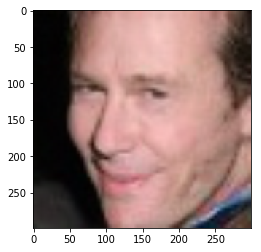

tensor(-27.2270, grad_fn=<SumBackward0>)
torch.Size([1, 3, 299, 299]) tensor([0])


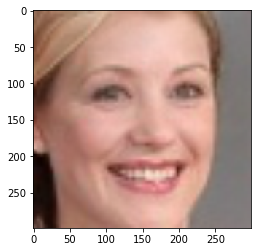

tensor(-30.2947, grad_fn=<SumBackward0>)


In [133]:
inception_net.eval()

for x,y in islice(progan_loader,2):
    print(x.shape, y)
    plt.imshow((x).squeeze().permute(1, 2, 0))
    plt.show()
    out = inception_net(x)
    print(out.sum())
    

In [135]:
[x.shape for x in example_activations]

[torch.Size([3226552]), torch.Size([3226552])]